In [1]:
# # %pwd
# %cd drive/MyDrive/'stuff after the mission'/'Fall 23'/'ECEN 758'

In [2]:
import data_loader_utility as dlu
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
train_dl, test_dl, val_dl = dlu.get_dataloaders()

In [5]:
X_train, X_test, y_train, y_test = dlu.get_tabular_data()

## 2 (a) Descriptive Statistics (e.g., class distributions, data statistics)

In [6]:
from matplotlib.ticker import MaxNLocator

Text(0, 0.5, '% of dataset made up by each class')

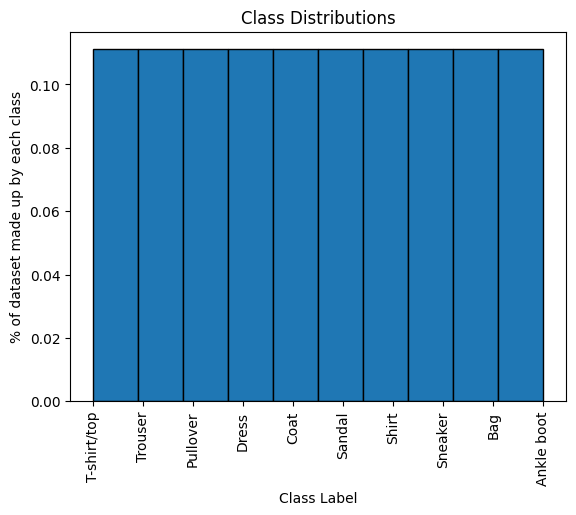

In [7]:
all_labels = np.concatenate([np.array(X_test), np.array(y_test)])
fig, ax = plt.subplots()
ax.hist(all_labels, density=True, edgecolor='black')
ax.set_title('Class Distributions')
ax.set_xlabel('Class Label')
ax.set_xticks(ticks=list(dlu.label_dict.keys()),  # TODO -- FIX THE XTICKS/LABELS
              labels=list(dlu.label_dict.values()),
              rotation=90)
ax.set_ylabel('% of dataset made up by each class')

## Use a pretrained ResNet50 neural network to create a feature vector for each image to use to train an XGBoost model

###### References: https://stackoverflow.com/questions/55083642/extract-features-from-last-hidden-layer-pytorch-resnet18

In [8]:
# from torchvision import models
# rn50 =  models.resnet50(weights='ResNet50_Weights.DEFAULT')
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # children_counter = 0
# # for n,c in rn50.named_children():
# #     print("Children Counter: ",children_counter," Layer Name: ",n,)
# #     children_counter+=1

In [9]:
feature_extractor = torch.nn.Sequential(*list(rn50.children())[:-1])

NameError: name 'rn50' is not defined

In [ ]:
# import torch.nn as nn
# class CustomResNet50(nn.Module):
#     def __init__(self, num_classes):
#         super(CustomResNet50, self).__init()
#         # Load the pre-trained ResNet-50 model
#         self.resnet50 = models.resnet50(pretrained=True)

#         # Modify the first layer to accept 28x28 images
#         self.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

#         # Modify the average pooling layer to adapt to the new input size
#         self.resnet50.avgpool = nn.AdaptiveAvgPool2d(1)

#         # Modify the final fully connected layer to match the number of output classes
#         self.resnet50.fc = nn.Linear(2048, num_classes)

#     def forward(self, x):
#         return self.resnet50(x)


In [ ]:
# x = torch.randn([1,3,27,27])
# custom_resnet = CustomResNet50(num_classes=10)

AttributeError: ignored

Building a model based on this model [here](https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/).

In [77]:
imgs, labels = next(iter(train_dl))
# plt.imshow(imgs[1].reshape(28,28), cmap='gray')
feat_map_gen_img = imgs[1] #.reshape(28,28)
feat_map_gen_img = feat_map_gen_img.to(device)

In [11]:
# import torch
import torch.nn as nn
import torch.optim as optim
import torchvision


batch_size = 32

class HomemadeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 28, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(28, 14, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.flat = nn.Flatten()

        self.fc4 = nn.Linear(14*7*7, 343)
        self.act4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.2)

        self.fc5 = nn.Linear(343, 10)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act4(self.fc4(x))
        x = self.drop4(x)
        x = self.fc5(x)
        return x


In [12]:
### TODO -- get the features out
### TODO -- fit an xgboost model
### TODO -- inspect the model performance metrics
### TODO -- tey out-of-sample predictions

model_ = HomemadeCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_.parameters(), lr=0.001, momentum=0.9)

n_epochs = 5  # experiment with adjusting this
for epoch in range(n_epochs):
    for inputs, labels in train_dl:
        # forward, backward, and then weight update
        labels = labels.to(device)
        inputs = inputs.to(device)
        y_pred = model_(inputs)#.to(device)
        loss = loss_fn(y_pred, labels)

        # double check what these are doing
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = 0
    count = 0
    for inputs, labels in val_dl:
        labels = labels.to(device)
        inputs = inputs.to(device)
        y_pred = model_(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

# torch.save(model.state_dict(), "homemademodel.pth")

Epoch 0: model accuracy 73.59%
Epoch 1: model accuracy 78.13%
Epoch 2: model accuracy 79.43%
Epoch 3: model accuracy 81.14%
Epoch 4: model accuracy 81.90%


In [78]:
def feature_map_generation(model_, feat_test_img):
    model_weights = []
    conv_layers = []
    outputs = []
    names = []
    processed = []
    model_children = list(model_.children())

    counter = 0
    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv2d:
            counter+=1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
    print("Total conv layers: ", counter)
    print("conv layers", conv_layers)

    for layer in conv_layers[0:]:
        feat_test_img = layer(feat_test_img)
        outputs.append(feat_test_img)
        names.append(str(layer))
    
    # for feature_map in outputs:
    #     print(feature_map.shape)
    
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())
    
    # for f in processed:
    #     print(f.shape)
    
    return processed, names


In [81]:
processed, names = feature_map_generation(model_, feat_map_gen_img)

Total conv layers:  2
conv layers [Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(28, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]


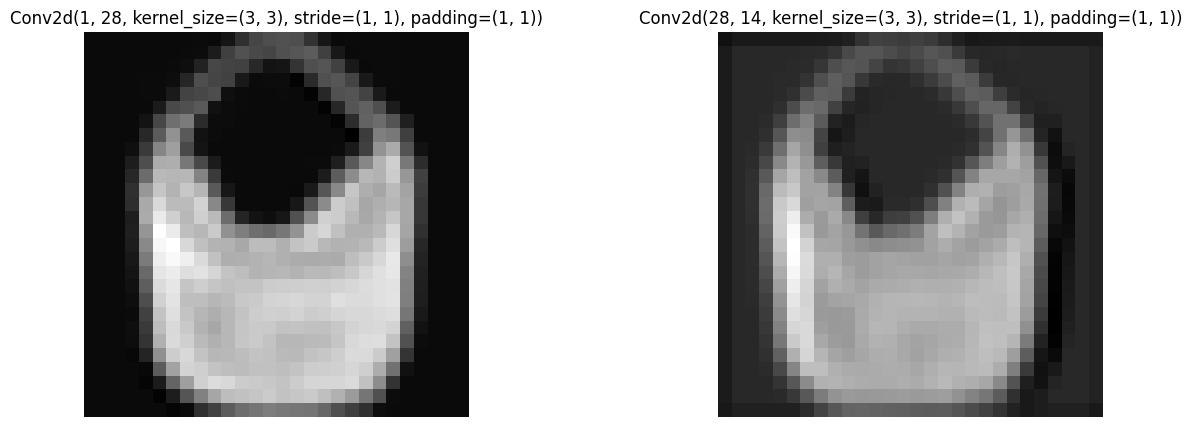

In [83]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for i in range(len(processed)):
    ax[i].imshow(processed[i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(names[i])

In [150]:
activation = {}

def hook_fn(module, input, output, layer_name):
    activation[layer_name] = output.detach()

# Register the hook to the layer of interest
target_layer = model_.conv2 # Example: Last convolutional layer of layer4
hook = target_layer.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'layer2_conv2'))

# Forward pass to get the final convolutional layer output
# with torch.no_grad():
output = model_(feat_map_gen_img.unsqueeze(0))


hook.remove()

# Get the activation map from the hook
activation_map = activation['layer2_conv2'].squeeze()

# Visualize the original image and the activation map
feat_map_gen_img=feat_map_gen_img.data.cpu().numpy()
activation_map=activation_map.data.cpu().numpy()
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(feat_map_gen_img)
plt.title('Original Image')
plt.axis('off')

# Activation Map
plt.subplot(1, 2, 2)
plt.imshow(activation_map[0], cmap='viridis')
plt.title('Activation Map')
plt.axis('off')

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

torch.Size([28, 1, 3, 3])
28


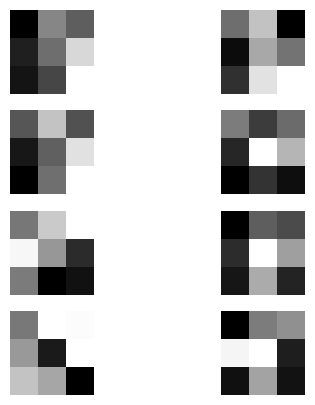

In [116]:
first_conv_filters = model_.conv1.weight.data
print(first_conv_filters.shape)
num_filters = first_conv_filters.size(0)
print(num_filters)
fig, ax = plt.subplots(4,2, figsize=(5,5))
ax = ax.flatten()
for i in range(num_filters):
    # print(first_conv_filters[i].reshape(3,3))
    ax[i].imshow(first_conv_filters[i].reshape(3,3).detach().cpu().numpy(), cmap='gray')
    ax[i].axis('off')
    if i == 7:
        break

In [13]:
acc = 0
count = 0

with torch.no_grad():
    for inputs, labels in test_dl:
        labels = labels.to(device)
        inputs = inputs.to(device)
        y_pred = model_(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)

In [14]:
acc / count  # 90%!! not bad :) - need to vet that though

tensor(0.8337, device='cuda:0')

In [10]:
(torch.argmax(y_pred, 1) == labels).float().sum()

tensor(14.)

Interpreting Convolutional Neural Network (CNN) models can be challenging due to their complex architectures and hierarchical feature representations. However, several techniques can help improve the interpretability of CNN models:

1. **Visualizing Activations:**
   - Visualize the activations of different layers to understand how the network processes input data. Activation maps can reveal which parts of the input images are being focused on by specific filters.

2. **Filter Visualization:**
   - Visualize the learned filters or convolutional kernels to gain insights into the features that the network has learned. This can help understand what kinds of patterns or textures each filter is sensitive to.

3. **Class Activation Maps (CAM):**
   - CAM highlights the regions of an input image that are most important for a particular class prediction. It helps localize which parts of the image contributed the most to the final decision.

4. **Gradient-weighted Class Activation Mapping (Grad-CAM):**
   - Grad-CAM is an extension of CAM that uses the gradients of the predicted class with respect to the feature maps. It produces a heatmap highlighting important regions in the input image.

5. **Layer-wise Relevance Propagation (LRP):**
   - LRP assigns relevance scores to different neurons or filters in the network, helping to understand the contribution of each feature to the final prediction.

6. **Saliency Maps:**
   - Saliency maps highlight the most relevant pixels in an input image with respect to a specific class. This method can help visualize what parts of the image the model is paying attention to when making predictions.

7. **Integrated Gradients:**
   - Integrated Gradients can be used to attribute the model's prediction to individual pixels in the input image. This method provides a sensitivity score for each pixel, indicating its contribution to the final prediction.

8. **Feature Visualization:**
   - Generate synthetic inputs that maximally activate specific neurons in the network. This technique can provide insights into what kind of patterns or features each neuron is responsive to.

9. **Transfer Learning with Explainability:**
   - If using a pre-trained CNN, consider using techniques like LIME or SHAP to generate interpretable explanations for specific predictions in the context of your application.

10. **Attention Mechanisms:**
    - If your CNN includes attention mechanisms (e.g., in a transformer-based architecture), analyze attention weights to understand which parts of the input are given more importance for the prediction.

11. **Quantitative Metrics:**
    - Use metrics such as class-specific accuracy, precision-recall curves, or confusion matrices to assess how well the model is performing on different classes. This can provide insights into potential biases or areas of improvement.

When interpreting CNN models, it's often beneficial to combine multiple techniques to obtain a more comprehensive understanding. Keep in mind that the choice of method may depend on the specific architecture of your CNN and the nature of your task. Additionally, consider using specialized libraries and tools designed for interpreting deep learning models, such as Captum for PyTorch or TensorBoard for TensorFlow.